<a href="https://colab.research.google.com/github/advaitds2021/Cureya-Internship/blob/main/Week5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **WEEK-5: STOCK PRICE PREDICTION- APPLE**

### **Data Dictionary:**

1. **High:**Maximum stock price during the trading day
2. **Low:**Minimum stock price during the trading day
3. **Open:**Stock price at the opening of the trading day
4. **Close:** Stock price at the closing of the trading day
5. **Volume:** Number of shares traded during the trading day

###1. Import required libraries and read data

In [101]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from numpy import array


In [2]:
# Get the stock quote
df = web.DataReader('AAPL',data_source='yahoo',start='2012-01-01',end='2019-12-17')

In [3]:
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,14.732143,14.607143,14.621429,14.686786,302220800.0,12.610315
2012-01-04,14.810000,14.617143,14.642857,14.765714,260022000.0,12.678085
2012-01-05,14.948214,14.738214,14.819643,14.929643,271269600.0,12.818838
2012-01-06,15.098214,14.972143,14.991786,15.085714,318292800.0,12.952841
2012-01-09,15.276786,15.048214,15.196429,15.061786,394024400.0,12.932299
...,...,...,...,...,...,...
2019-12-11,67.775002,67.125000,67.202499,67.692497,78756800.0,66.799057
2019-12-12,68.139999,66.830002,66.945000,67.864998,137310400.0,66.969292
2019-12-13,68.824997,67.732498,67.864998,68.787498,133587600.0,67.879601


In [4]:
#We drop date column as it is not required for further analysis
df = df.reset_index(drop=True)
df.head()

,High,Low,Open,Close,Volume,Adj Close
0,14.732143,14.607143,14.621429,14.686786,302220800.0,12.610315
1,14.810000,14.617143,14.642857,14.765714,260022000.0,12.678085
2,14.948214,14.738214,14.819643,14.929643,271269600.0,12.818838
3,15.098214,14.972143,14.991786,15.085714,318292800.0,12.952841
4,15.276786,15.048214,15.196429,15.061786,394024400.0,12.932299


**2. Data Visualization:**

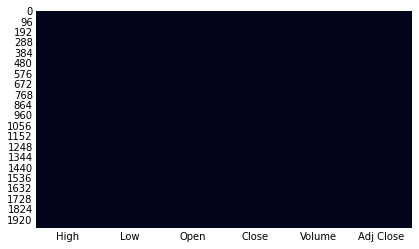

In [5]:
sns.heatmap(df.isnull(), cbar=False)
plt.show()

**Interpretation:** From the heatmap it is clear that the data has no missing values

**Scatterplot: High vs Volume**

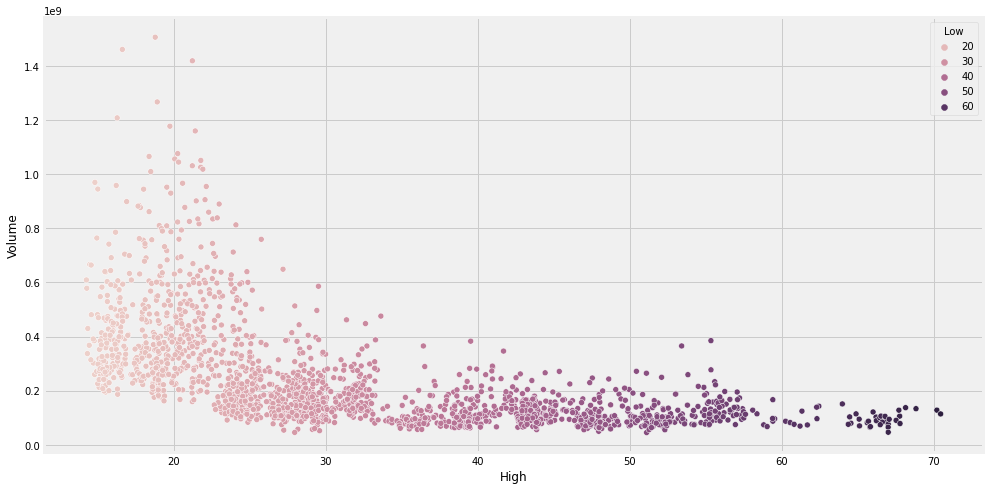

In [6]:
plt.figure(figsize=(15,8))
sns.scatterplot(x='High',y='Volume',hue='Low',data=df)
plt.show()

**Consider closing date feature to analyze stocks and make prediction**

In [9]:
df1 = df.reset_index()['Close']

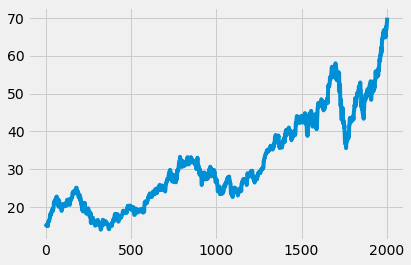

In [ ]:
plt.plot(df1)
plt.show()


#### **The variation in stock price is varying non-linearly and hence it is difficult to make predictions.**

#### **We can achieve it efficiently using LSTM(Long-Short term memory layer)**

### 5. Train-Test Split

Let us analyze stock price at closing of the trading day during the given interval

**Data Standardization**

In [52]:
minscaler = MinMaxScaler(feature_range=(0,1))
df1 = minscaler.fit_transform(np.array(df1).reshape(-1,1))
df1

array([[0.01316509],
       [0.01457063],
       [0.01748985],
       ...,
       [0.97658263],
       [0.99755134],
       [1.        ]])

In [54]:
#Split the dataset into train and test
training_size = int(len(df1)*0.8)
test_size = len(df1) - training_size
train_data, test_data = df1[0:training_size,:], df1[training_size:len(df1),:1]

In [55]:
def create_dataset(dataset, time_step=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-time_step-1):
    a= dataset[i:(i+time_step),0]
    dataX.append(a)
    dataY.append(dataset[i+ time_step, 0])
  return np.array(dataX), np.array(dataY)

In [56]:
time_step=100
X_train, y_train = create_dataset(train_data,time_step)
X_test, y_test = create_dataset(test_data,time_step)

In [57]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1501, 100)
(300, 100)
(1501,)
(300,)


In [58]:
#Reshape train and test data which is further required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],1)


### 6. Predict the stock prices using RNN

In [83]:
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [84]:
print(model.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 100, 50)           10400     
_________________________________________________________________
lstm_19 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________
None


In [85]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
24/24 [==============================] - 7s 148ms/step - loss: 0.0103 - val_loss: 0.0052
Epoch 2/100
24/24 [==============================] - 3s 118ms/step - loss: 7.8440e-04 - val_loss: 0.0022
Epoch 3/100
24/24 [==============================] - 3s 119ms/step - loss: 3.7457e-04 - val_loss: 0.0019
Epoch 4/100
24/24 [==============================] - 3s 118ms/step - loss: 3.4727e-04 - val_loss: 0.0019
Epoch 5/100
24/24 [==============================] - 3s 117ms/step - loss: 3.4204e-04 - val_loss: 0.0018
Epoch 6/100
24/24 [==============================] - 3s 116ms/step - loss: 3.2420e-04 - val_loss: 0.0017
Epoch 7/100
24/24 [==============================] - 3s 118ms/step - loss: 3.1616e-04 - val_loss: 0.0016
Epoch 8/100
24/24 [==============================] - 3s 119ms/step - loss: 3.1611e-04 - val_loss: 0.0016
Epoch 9/100
24/24 [==============================] - 3s 118ms/step - loss: 3.0956e-04 - val_loss: 0.0017
Epoch 10/100
24/24 [==============================] - 3s 11

In [18]:
#Check the version of tensor flow
tf.__version__

'2.6.0'

In [86]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [87]:
train_predict = minscaler.inverse_transform(train_predict)
test_predict = minscaler.inverse_transform(test_predict)

### 8. Plot a graph after prediction by using different colours to show predicted stocks

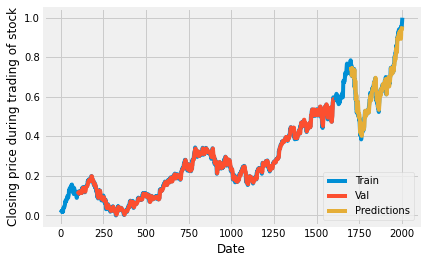

In [95]:
look_back = 100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
testPredictPlot = np.empty_like(df1)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict) + (look_back*2) +1 : len(df1)-1, :] = test_predict
plt.plot(minscaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.xlabel("Date")
plt.ylabel("Closing price during trading of stock")
plt.legend(["Train","Val","Predictions"],loc='lower right')

plt.show()


### 9. Add an Evaluation metrics

**Calculate RMSE**

In [90]:
#RMSE for train data
train_mse = mean_squared_error(y_train,train_predict)
RMSE_train = np.sqrt(train_mse)
print("RMSE for train is:",round(RMSE_train,2))


RMSE for train is: 0.01


In [91]:
test_rmse = mean_squared_error(y_test, test_predict)
RMSE_test = np.sqrt(test_rmse)
print("RMSE for test is:", round(RMSE_test,2))

RMSE for test is: 0.02


### 10. Predict the stocks (30 days)

In [97]:
len(test_data)

401

In [98]:
x_input = test_data[301:].reshape(1,-1)


In [99]:
x_input.shape

(1, 100)

In [100]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [ ]:
lst_output = []
n_steps= 100
i =0
while (i<30):
  if(len(temp_input)>100):
    x_input = np.array(temp_input[1:])
    print("{} day input {}".format(i,x_input))
    x_input = x_input.reshape(1,-1)
    x_input = x_input.reshape((1, n_steps, 1))
    yhat = model.predict(x_input, verbose=0)
    print("{} day output {}".format(i,yhat))
    temp_input.extend(yhat[0].tolist())
    temp_input = temp_input[1:]
    lst_output.extend(yhat.tolist())
    i = i+1
  else:
      x_input = x_input.reshape((1, n_steps, 1))
      yhat = model.predict(x_input, verbose=0)
      print(yhat[0])
      temp_input.extend(yhat[0].tolist())
      print(len(temp_input))
      lst_output.extend(yhat.tolist())
      i = i+1

In [104]:
day_new = np.arange(1,101)
day_pred = np.arange(101,131)

In [106]:
df3 = df1.tolist()
df3.extend(lst_output)

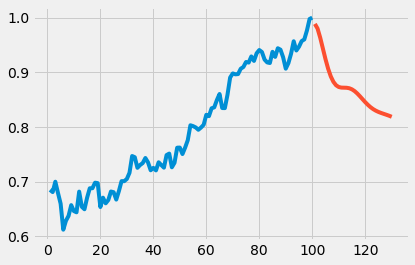

In [108]:
# 30 days output
plt.plot(day_new, minscaler.inverse_transform(df1[1903:]))
plt.plot(day_pred,minscaler.inverse_transform(lst_output))
plt.show()

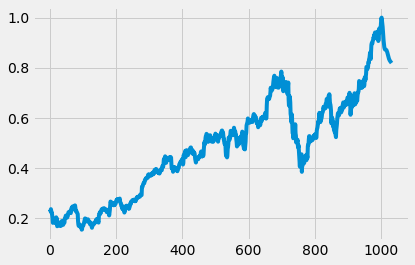

In [110]:
# Combined output
df3 = df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1000:])
plt.show()